In [1]:
import numpy as np
from loadmodules import *
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors

%matplotlib inline
rcParams['figure.facecolor'] = 'white'

In [2]:
# path = './Auriga_SC/K12_fiducial/'
path = './'
simulation_list = [directory for directory in os.listdir(path) if 'Au6_lvl4_cfea' in directory]
print(simulation_list)

['Au6_lvl4_cfea_emosaics', 'Au6_lvl4_cfea_sh50myr10', 'Au6_lvl4_cfea_compressive', 'Au6_lvl4_cfea_sh50myr50', 'Au6_lvl4_cfea_scbase', 'Au6_lvl4_cfea_fiducial']


In [19]:
sim_id = 1
snap_id = 127
print('Loading simulation ', simulation_list[sim_id], ' snapshot ', snap_id)
sf = load_subfind(snap_id, dir=path+simulation_list[sim_id]+'/output/', hdf5=True, loadonly=['fpos', 'frc2', 'svel', 'flty', 'fnsh', 'slty', 'spos', 'smty', 'ffsh'] )
s = gadget_readsnap(snap_id, snappath=path+simulation_list[sim_id]+'/output/', subfind=sf, hdf5=True, applytransformationfacs=True, loadonlyhalo=0)
s.calc_sf_indizes( sf )
galrad = 0.75 * sf.data['frc2'][0]
s.select_halo( sf, use_principal_axis=True, use_cold_gas_spin=False, do_rotation=True )

Loading simulation  Au6_lvl4_cfea_sh50myr10  snapshot  127
galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated bfld.
Rotated vel.


array([[-0.05904483,  0.35439216,  0.93323089],
       [ 0.49324374, -0.80241338,  0.3359217 ],
       [ 0.86788497,  0.48014474, -0.12742336]])

In [20]:
solar_mass_g = 1.989e33
Gcosmo = 43.
k = 1.3807e-16 # boltzmann constant in erg/K (g*cm^2/s^2/K)
parsec = 3.08567758e18 # cm
gyr = 3.15576e16 # seconds

s.parameters['UnitTime_in_s'] = s.parameters['UnitLength_in_cm']/s.parameters['UnitVelocity_in_cm_per_s']

In [21]:
starparts = (s.data['age'] > 0) * (s.r()[s.data['type']==4]<galrad)
mask_cluster_initial = (s.data['incl'][starparts]>0)
mask_cluster_final = (s.data['nclt'][starparts]>0)
truncation_mass = s.data['mtrc'][starparts][mask_cluster_initial] * s.UnitMass_in_g/solar_mass_g
cluster_masses = s.data['mclt'][starparts][mask_cluster_initial].flatten()*s.UnitMass_in_g/solar_mass_g
cluster_radius = s.data['rclt'][starparts][mask_cluster_initial].flatten()*s.UnitLength_in_cm/parsec
init_cluster_masses = s.data['imcl'][starparts][mask_cluster_initial].flatten()*s.UnitMass_in_g/solar_mass_g
init_cluster_radius = s.data['ircl'][starparts][mask_cluster_initial].flatten()*s.UnitLength_in_cm/parsec
masslostrelax = s.data['mlrx'][starparts][mask_cluster_initial].flatten()*s.UnitMass_in_g/solar_mass_g
masslostshock = s.data['mlsk'][starparts][mask_cluster_initial].flatten()*s.UnitMass_in_g/solar_mass_g


In [22]:
not_empty_clusters = (init_cluster_masses>0)

cluster_masses = cluster_masses[not_empty_clusters]
cluster_radius = cluster_radius[not_empty_clusters]
init_cluster_masses = init_cluster_masses[not_empty_clusters]
init_cluster_radius = init_cluster_radius[not_empty_clusters]
masslostrelax = masslostrelax[not_empty_clusters]
masslostshock = masslostshock[not_empty_clusters]

print('Maximum initial mass {:2.2e} Msun'.format(init_cluster_masses.max()))
print('Maximum present-day mass {:2.2e} Msun'.format(cluster_masses.max()))

Maximum initial mass 5.35e+07 Msun
Maximum present-day mass 2.42e+07 Msun


In [23]:
clusters_formtime = np.repeat(s.data['age'][starparts][mask_cluster_initial], s.data['incl'][starparts][mask_cluster_initial])
clusters_age = s.cosmology_get_lookback_time_from_a(clusters_formtime, is_flat=True) - s.cosmology_get_lookback_time_from_a(s.time, is_flat=True)

In [24]:
cluster_disruptiontime = s.data['drpt'][starparts][mask_cluster_initial].flatten()
cluster_disruptiontime = s.cosmology_get_lookback_time_from_a(cluster_disruptiontime[not_empty_clusters], is_flat=True)

In [25]:
lifetime_gyr = clusters_age - cluster_disruptiontime
lifetime_gyr[lifetime_gyr<0] = 20.

In [26]:
young_mask = (clusters_age<0.5)
old_mask = (clusters_age>6.)
veryold_mask = (clusters_age>10.)

In [27]:
def density_scatter( x , y, vmin, vmax, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density=False)
    z = sp.interpolate.interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    h = ax.scatter( x, y, c=z, norm=mcolors.LogNorm(vmin=vmin, vmax=vmax),cmap=cm.viridis, **kwargs )

    return ax, h

In [28]:
min_icmf = 5e3 # in solar masses
max_icmf = 1e8 # in solar masses
marray_icmf = np.logspace(np.log10(min_icmf), np.log10(max_icmf), 25)

min_gcmf = 1e2 # in solar masses
max_gcmf = 1e8 # in solar masses
marray_gcmf = np.logspace(np.log10(min_gcmf), np.log10(max_gcmf), 25)

min_rh = 1e-2 # in parsecs
max_rh = 2e2 # in parsecs
rharray = np.logspace(np.log10(min_rh), np.log10(max_rh), 25) # in pc

In [ ]:
# mw_rhdist = np.loadtxt('MW_rh.csv', delimiter=',')
# m31_rhdist = np.loadtxt('M31_rh.csv', delimiter=',')
# m83_rhdist = np.loadtxt('M83_rh.csv', delimiter=',')

# emp_rhyoung = np.loadtxt('emp_young_rh.csv', delimiter=',')
# emp_rh6gyr = np.loadtxt('emp_6gyr_rh.csv', delimiter=',')
# emp_rh10gyr = np.loadtxt('emp_10gyr_rh.csv', delimiter=',')

In [29]:
lossratio = masslostshock/masslostrelax

Text(0, 0.5, 'Number')

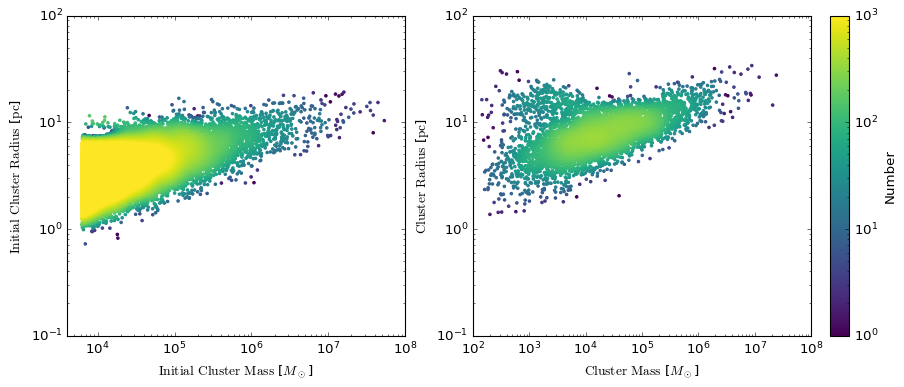

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0], cb = density_scatter(init_cluster_masses, init_cluster_radius, vmin=1e0, vmax=1e3, ax=ax[0],bins=[marray_icmf, rharray], edgecolors='face', s=5)
ax[0].set(xscale='log', yscale='log', xlim=(4e3, 1e8), ylim=(1e-1, 1e2), xlabel=r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', ylabel=r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Radius}$ [$\rm{pc}$]')
ax[1], cb = density_scatter(cluster_masses, cluster_radius, vmin=1e0, vmax=1e3, ax=ax[1],bins=[marray_gcmf, rharray], edgecolors='face', s=5)
ax[1].set(xscale='log', yscale='log', xlim=(1e2, 1e8), ylim=(1e-1, 1e2), xlabel=r'$\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', ylabel=r'$\rm{Cluster}$ $\rm{Radius}$ [$\rm{pc}$]')

cbar = fig.colorbar(cb, cax=fig.add_axes([0.92, 0.1, 0.02, 0.8]))
cbar.ax.set_ylabel('Number')

Text(0, 0.5, 'Number')

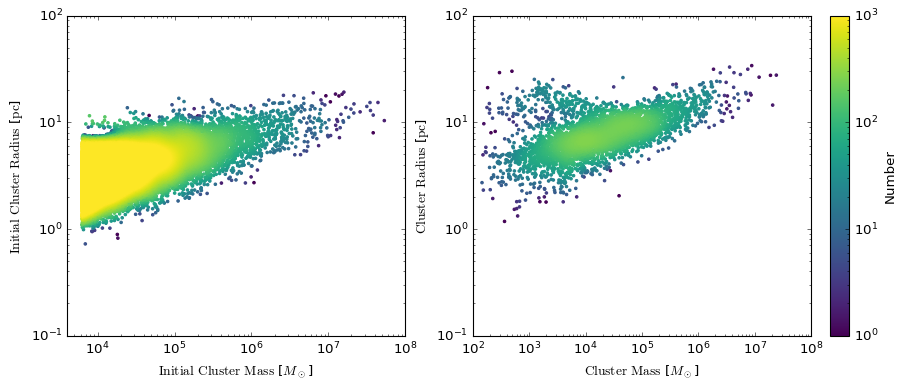

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0], cb = density_scatter(init_cluster_masses, init_cluster_radius, vmin=1e0, vmax=1e3, ax=ax[0],bins=[marray_icmf, rharray], edgecolors='face', s=5)
ax[0].set(xscale='log', yscale='log', xlim=(4e3, 1e8), ylim=(1e-1, 1e2), xlabel=r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', ylabel=r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Radius}$ [$\rm{pc}$]')
ax[1], cb = density_scatter(cluster_masses, cluster_radius, vmin=1e0, vmax=1e3, ax=ax[1],bins=[marray_gcmf, rharray], edgecolors='face', s=5)
ax[1].set(xscale='log', yscale='log', xlim=(1e2, 1e8), ylim=(1e-1, 1e2), xlabel=r'$\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', ylabel=r'$\rm{Cluster}$ $\rm{Radius}$ [$\rm{pc}$]')

cbar = fig.colorbar(cb, cax=fig.add_axes([0.92, 0.1, 0.02, 0.8]))
cbar.ax.set_ylabel('Number')

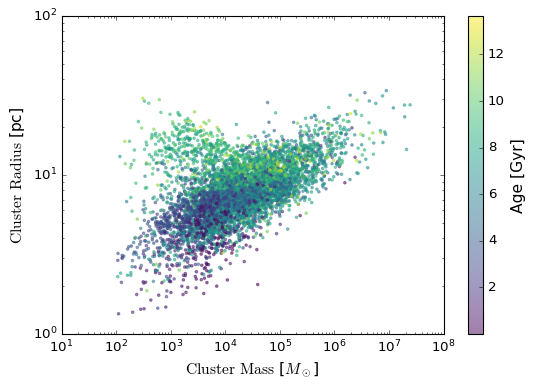

In [15]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
cb = ax.scatter(cluster_masses, cluster_radius, c=clusters_age, cmap=cm.viridis, s=5, alpha=0.5, edgecolors='face')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', fontsize=14)
ax.set_ylabel(r'$\rm{Cluster}$ $\rm{Radius}$ [pc]', fontsize=14)
cbar = fig.colorbar(cb)
cbar.set_label('Age [Gyr]', fontsize=14)
plt.tick_params(labelsize=12)
fig.axes[1].tick_params(labelsize=12)
plt.tight_layout()
# plt.savefig('final_mass_radius.png')

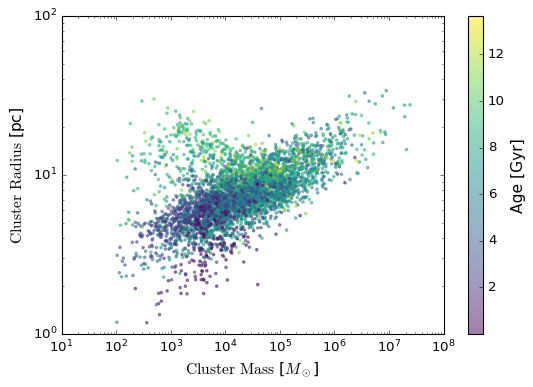

In [32]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
cb = ax.scatter(cluster_masses, cluster_radius, c=clusters_age, cmap=cm.viridis, s=5, alpha=0.5, edgecolors='face')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e0, 1e2)
ax.set_xlabel(r'$\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', fontsize=14)
ax.set_ylabel(r'$\rm{Cluster}$ $\rm{Radius}$ [pc]', fontsize=14)
cbar = fig.colorbar(cb)
cbar.set_label('Age [Gyr]', fontsize=14)
plt.tick_params(labelsize=12)
fig.axes[1].tick_params(labelsize=12)
plt.tight_layout()
# plt.savefig('final_mass_radius.png')

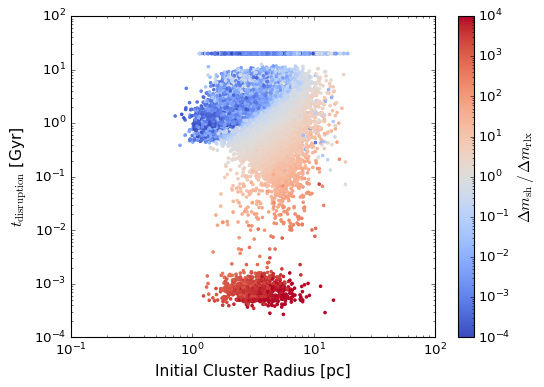

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
cb = ax.scatter(init_cluster_radius, lifetime_gyr, edgecolors='face', s=5, c=lossratio, cmap=cm.coolwarm, norm=mcolors.LogNorm(vmin=1e-4, vmax=1e4))
ax.set(xscale='log', yscale='log')#, xlim=(5e-2, 2e2), ylim=(1e-3, 2e1))
ax.set_xlabel('Initial Cluster Radius [pc]', fontsize=14)
ax.set_ylabel(r'$t_{\rm{disruption}}$ [Gyr]', fontsize=14)
cbar = fig.colorbar(cb)
cbar.set_label(r'$\Delta m_\mathrm{sh} \, / \, \Delta m_\mathrm{rlx}$', fontsize=14)
plt.tick_params(labelsize=12)
fig.axes[1].tick_params(labelsize=12)
plt.tight_layout()
# plt.savefig('lifetime_radius.png')

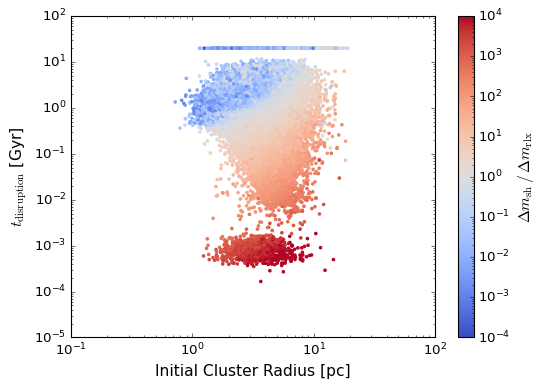

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
cb = ax.scatter(init_cluster_radius, lifetime_gyr, edgecolors='face', s=5, c=lossratio, cmap=cm.coolwarm, norm=mcolors.LogNorm(vmin=1e-4, vmax=1e4))
ax.set(xscale='log', yscale='log')#, xlim=(5e-2, 2e2), ylim=(1e-3, 2e1))
ax.set_xlabel('Initial Cluster Radius [pc]', fontsize=14)
ax.set_ylabel(r'$t_{\rm{disruption}}$ [Gyr]', fontsize=14)
cbar = fig.colorbar(cb)
cbar.set_label(r'$\Delta m_\mathrm{sh} \, / \, \Delta m_\mathrm{rlx}$', fontsize=14)
plt.tick_params(labelsize=12)
fig.axes[1].tick_params(labelsize=12)
plt.tight_layout()
# plt.savefig('lifetime_radius.png')

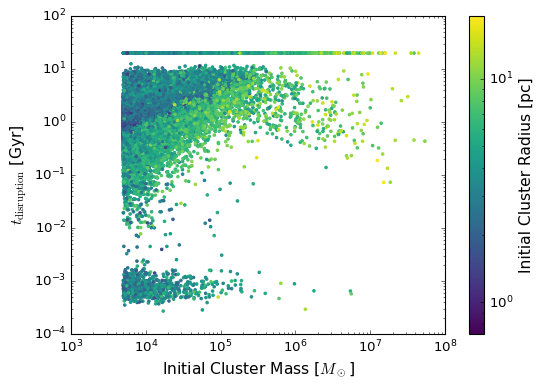

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
cb = ax.scatter(init_cluster_masses, lifetime_gyr, edgecolors='face', s=5, c=init_cluster_radius, cmap=cm.viridis, norm=mcolors.LogNorm())
ax.set(xscale='log', yscale='log')#, xlim=(4e3, 1e8), ylim=(1e-3, 2e1))
ax.set_xlabel(r'Initial Cluster Mass [$M_\odot$]', fontsize=14)
ax.set_ylabel(r'$t_{\rm{disruption}}$ [Gyr]', fontsize=14)
cbar = fig.colorbar(cb, ax=ax)
cbar.set_label('Initial Cluster Radius [pc]', fontsize=14)
plt.tick_params(labelsize=12)
fig.axes[1].tick_params(labelsize=12)
plt.tight_layout()
# plt.savefig('initial_mass_lifetime.png')

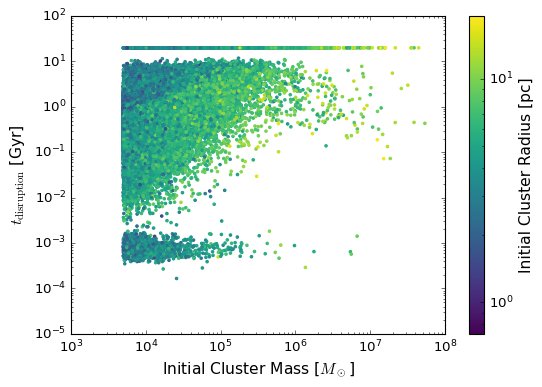

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
cb = ax.scatter(init_cluster_masses, lifetime_gyr, edgecolors='face', s=5, c=init_cluster_radius, cmap=cm.viridis, norm=mcolors.LogNorm())
ax.set(xscale='log', yscale='log')#, xlim=(4e3, 1e8), ylim=(1e-3, 2e1))
ax.set_xlabel(r'Initial Cluster Mass [$M_\odot$]', fontsize=14)
ax.set_ylabel(r'$t_{\rm{disruption}}$ [Gyr]', fontsize=14)
cbar = fig.colorbar(cb, ax=ax)
cbar.set_label('Initial Cluster Radius [pc]', fontsize=14)
plt.tick_params(labelsize=12)
fig.axes[1].tick_params(labelsize=12)
plt.tight_layout()
# plt.savefig('initial_mass_lifetime.png')

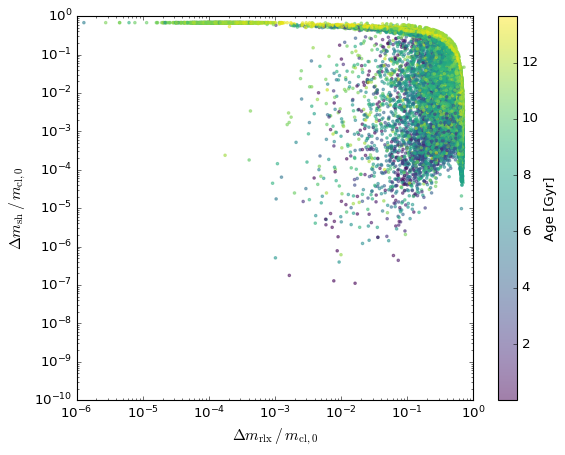

In [18]:
plt.scatter(masslostrelax/init_cluster_masses, masslostshock/init_cluster_masses, s=5, c=clusters_age, cmap=cm.viridis, edgecolors='face', alpha=0.5)
plt.xlabel(r'$\Delta m_\mathrm{rlx} \, / \, m_{\rm{cl,0}}$', fontsize=14)
plt.ylabel(r'$\Delta m_\mathrm{sh} \, / \, m_{\rm{cl,0}}$', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-6, 1)
plt.ylim(1e-10, 1)
plt.colorbar(label='Age [Gyr]')

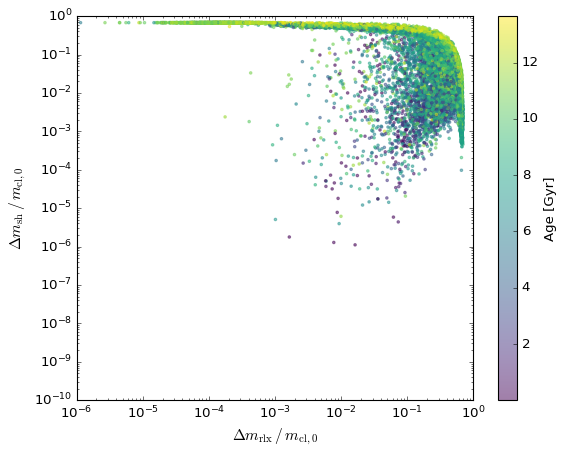

In [35]:
plt.scatter(masslostrelax/init_cluster_masses, masslostshock/init_cluster_masses, s=5, c=clusters_age, cmap=cm.viridis, edgecolors='face', alpha=0.5)
plt.xlabel(r'$\Delta m_\mathrm{rlx} \, / \, m_{\rm{cl,0}}$', fontsize=14)
plt.ylabel(r'$\Delta m_\mathrm{sh} \, / \, m_{\rm{cl,0}}$', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-6, 1)
plt.ylim(1e-10, 1)
plt.colorbar(label='Age [Gyr]')